# Churn Drivers

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import graphviz
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind, pearsonr


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore")
import prep



# Hypotheses

- The month in which a customer signs up will have an impact on the rate of churn.
- Features like internet service, type of phone service, online security and backup, senior citizens will affect the rate of churn.
- There will be a price point on some of the serves where churn will increse.
- The contract plan will affect the rate of churn.

# Acquisition


In [2]:
# Get churn data from customers table
df = pd.read_csv('telco_churn_customers.csv')
df = prep.prep_telco(df)

In [3]:
df.drop(columns='customer_id', axis=1, inplace=True)

In [4]:
def peekatdata(dataframe):
    head_df = df.head()
    tail_df = df.tail()
    head_tail = head_df.append(tail_df)
    print('Head and Tail\n\n', head_tail)
    print('--'*55)
    shape_tuple = df.shape
    print('Shape\n\n', shape_tuple)
    print('--'*20)
    describe_df = df.describe()
    print('Describe\n\n', describe_df)
    print('--'*20)
    print('Index\n\n', df.index)
    print('--'*20)
    print('Data Types\n\n', df.dtypes)
    print('--'*20)
    print('Null Value Count\n\n', df.isnull().sum())
    print('--'*55)
    print('Memory\n\n', df.memory_usage)

# Data Prep


In [5]:
def df_value_counts(df):
    for col in df.columns: 
        n = df[col].unique().shape[0] 
        col_bins = min(n,10) 
        if df[col].dtype in ['int64','float64'] and n > 10:
            print('%s:' % col)
            print(df[col].value_counts(bins=col_bins, sort=False)) 
        else: 
            print(df[col].value_counts()) 
        print('\n')


### Missing Values

We only found a few missing values in the total_charges column where tenure was 0. There was an empty string in that field so we replaced it with a 0 since a customer with 0 tenure would have 0 total charges due. Could not find any other nulls or NaNs. 



In [6]:
# Split the data into train (70%) & test (30%) samples.
X = df.drop(['churn'], axis=1)
y = df[['churn']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=123, stratify= y)


In [7]:
# Numeric Scaling: scale the monthly_charges and total_charges data. Make sure that the parameters for scaling 
# are learned from the training data set.
scaler = MinMaxScaler()
scaler.fit(X_train[['monthly_charges', 'total_charges']])

X_train[['monthly_charges', 'total_charges']] = scaler.transform(X_train[['monthly_charges', 'total_charges']])
X_test[['monthly_charges', 'total_charges']] = scaler.transform(X_test[['monthly_charges', 'total_charges']])

In [8]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Data Exploration


In [9]:
train['cumsum_churn'] = train.churn.cumsum()
train['rate_churn'] = train.cumsum_churn/train.churn.count()

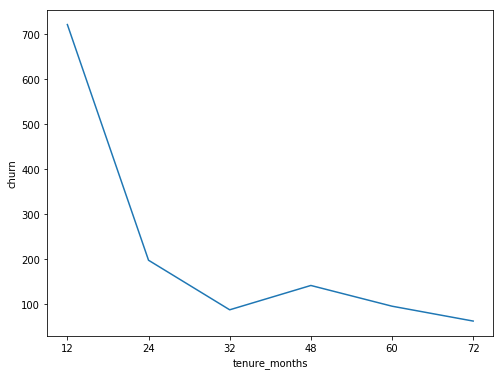

In [10]:
# Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a 
# cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart 
# where x is the tenure and y is the rate of churn (customers churned/total customers)).

bins = [12, 24, 32, 48, 60, 72]
train['tenure_months'] = pd.cut(train['tenure'], bins)

bins = [0, 12, 24, 32, 48, 60, 72]
labels = ['12', '24', '32', '48', '60', '72']
train['tenure_months'] = pd.cut(train['tenure'], bins=bins, labels=labels).where(train.churn == 1)

df1 = train.groupby('tenure_months')['churn'].count()
df1 = pd.DataFrame(df1)
df1 = df1.reset_index()
df1

plt.figure(figsize=(8,6))
ax = sns.lineplot(x="tenure_months", y="churn",data=df1)

Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

- A few of the features have a much higher percentage for churn:
- internet_service_type_id, contract_type_id, payment_type_id, device_protection, tech_support, senior_citizen

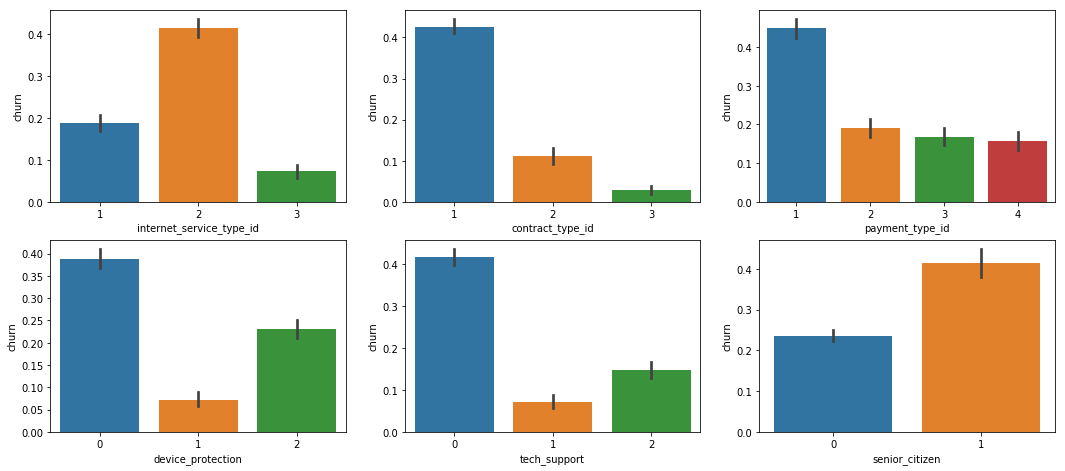

In [11]:
plt.figure(figsize=(18,12))

plt.subplot(331)
sns.barplot(x=train.internet_service_type_id, y=train.churn)

plt.subplot(332)
sns.barplot(x=train.contract_type_id, y=train.churn)

plt.subplot(333)
sns.barplot(x=train.payment_type_id, y=train.churn)

plt.subplot(334)
sns.barplot(x=train.device_protection, y=train.churn)

plt.subplot(335)
sns.barplot(x=train.tech_support, y=train.churn)

plt.subplot(336)
sns.barplot(x=train.senior_citizen, y=train.churn)

Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

In [12]:
# If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers
# after the 12th month, are those rates comparable?

mtm = train[train.contract_type_id == 1]
mtm_after12 = mtm[mtm.tenure_year > 1]

mtmc = mtm_after12.churn.value_counts()
mtmc

print('Rate of churn for month-to-month: {:.2%}'.format(mtmc[1]/(mtmc[0]+mtmc[1])))

one_year = train[train.contract_type_id == 2]
one_year_after12 = one_year[one_year.tenure_year > 1]

one_yearc = one_year_after12.churn.value_counts()
one_yearc

print('Rate of churn for 1+ years: {:.2%}'.format(one_yearc[1]/(one_yearc[0]+one_yearc[1])))

Rate of churn for month-to-month: 33.53%
Rate of churn for 1+ years: 11.48%


Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

- statistic: 13.57
- pvalue: 3.18e-41
- From the TTest we can conclude there is a significantly difference between the two.

In [13]:
# Getting customers who have duplicate services.

dups = train[train.duplicated(['phone_id', 
                               'internet_service_type_id', 
                               'online_security_backup',
                               'device_protection', 
                               'tech_support', 
                               'contract_type_id'],
                                keep=False)]


In [14]:
# Finding the monthly_charges for the ones who have churned/not

churn = dups.loc[dups['churn'] == 1]['monthly_charges']
no_churn = dups.loc[dups['churn'] == 0]['monthly_charges']

In [15]:
# T test on the mean monthly_charges

ttest_ind(churn,no_churn)

Ttest_indResult(statistic=13.780089052045543, pvalue=2.039715011078695e-42)

How much of monthly_charges can be explained by internet_service_type? (hint: correlation test). State your hypotheses and your conclusion clearly.

- hypotheses: The internet_service_type will have an impact on the amount of monthly_charges. 
- conclusion: 31.9% of the varriance in monthly_charges can be explained by the internet_service_type.

In [16]:
pearsonr(train.monthly_charges, train.internet_service_type_id)

(-0.3236727414058814, 1.3145249985768094e-120)

In [17]:
# plt.figure(figsize=(20,20))
# sns.heatmap(train.corr(), annot=True, cmap='Greens')

In [18]:
# pd.crosstab(train.churn, train.contract_type_id, margins=True, normalize=True).style.background_gradient(cmap='YlOrRd')


In [19]:
# scatter = pd.scatter_matrix(
#     train.drop(['customer_id'], axis=1), marker='o', s=40,
#     hist_kwds={'bins':15},  figsize=(25,25))

In [20]:
# sns.swarmplot(data=train, x='contract_type_id', y='monthly_charges', hue='churn')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [21]:
# sns.pairplot(data=train)

In [22]:
# sns.jointplot(x=train.monthly_charges, y=train.rate_churn, data=train)

In [23]:
# sns.relplot(data=train, x='tenure', y='total_charges', hue='churn')

In [24]:
# sns.distplot(train.tenure)

In [25]:
# sns.distplot(train.contract_type_id)

In [26]:
# sns.boxplot(data=train[['monthly_charges', 'total_charges']])


In [27]:
# with sns.axes_style('white'):
#     j = sns.jointplot("monthly_charges", "churn", data=train, kind='reg', height=5);
#     j.annotate(pearsonr)
# plt.show()

In [28]:
# g = sns.PairGrid(train)
# g.map_diag(plt.hist)
# g.map_offdiag(plt.scatter);


- According to the above, the variables that do not have a strong enough correlation are gender, steaming services, house type,  and phone_id. We will drop these for our analysis. 
- The variables that do have a significant effect on churn rate are internet_service_type_id, contract_type_id, payment_type_id, device_protection, tech_support, and senior_citizen. We will focus on these fetures.  


- internet_service_type_id: Faster plans have higher cost and higher monthly bills drive churn.
- contract_type_id: month to month have the freedom to churn whenever so if they have higher monthly bills they are free to leave. 
- payment_type_id: 
- device_protection: Broken devices can lead them to leave 
- tech_support: No support can leadto frustration and cause them to churn
- senior_citizen: More likely to stop service for health/moving issues.

### Feature Engineer

- total_charges can be found from combing tenure and monthly_charges so we will drop that one to avoid repeating data


In [29]:
train = train.drop(columns= ['total_charges', 
           'tenure_year', 
           'household_type_id', 
           'streaming_services', 
           'phone_id', 
           'online_security_backup',
           'gender',
           'cumsum_churn',
           'rate_churn',
           'tenure_months',
           'churn',
           'senior_citizen',
           'paperless_billing',
           'payment_type_id',
            'device_protection',
            'tech_support',
            'tenure'], axis=1)



In [30]:
# train = train.drop(columns= [
#            'cumsum_churn',
#            'rate_churn',
#            'tenure_months',
#            'churn'], axis=1)

# test = test.drop(columns= [
#            'churn',
#           ], axis=1)


In [31]:
test = test.drop(columns= ['total_charges', 
           'tenure_year', 
           'household_type_id', 
           'streaming_services', 
           'phone_id', 
           'online_security_backup',
           'gender',
           'churn',
           'senior_citizen',
           'paperless_billing',
           'payment_type_id',
            'device_protection',
            'tech_support',
            'tenure'], axis=1)

In [32]:
train

,internet_service_type_id,contract_type_id,monthly_charges
4953,3,2,0.014428
534,2,2,0.894030
172,1,3,0.321393
3710,3,3,0.057214
1574,2,2,0.820896
5931,1,1,0.266169
3558,2,1,0.506965
4949,1,2,0.266169
4447,2,2,0.771144
135,1,1,0.410945


In [33]:
test.shape

(2113, 3)

# Modeling

### Logistic Regression

In [34]:
# # # All fetures with no HP

# logis = LogisticRegression(random_state = 123)
# logis.fit(train, y_train)
# y_pred = logis.predict(train)
# print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
#      .format(logis.score(train, y_train)))
# print(confusion_matrix(y_train, y_pred))
# print(classification_report(y_train, y_pred))

# cm = confusion_matrix(y_train, y_pred)
# print(cm)
# print(classification_report(y_train, y_pred))
# tn = cm[0,0]
# tp = cm[1,1]
# fn = cm[1,0]
# fp = cm[0,1]
# total = cm.sum()
# accuracy = ((tn + tp)/total)*100
# print((fp/(fp + tn))*100)
# print((fn/(fn + tp))*100)

# y_pred_test = logis.predict(test)

# print('Accuracy of Decision Tree classifier on test set: {:.2f}'
#      .format(knn.score(test, y_test)))

# print(classification_report(y_test, y_pred_test))

### Decision Tree

In [64]:
# All fetures with no HP

dtc = DecisionTreeClassifier(criterion='gini', class_weight= 'balanced', max_depth=9, random_state=123)
dtc.fit(train, y_train)
y_pred_dtc = dtc.predict(train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(train, y_train)))

cm = confusion_matrix(y_train, y_pred_dtc)
print(cm)
print(classification_report(y_train, y_pred_dtc))
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
total = cm.sum()
accuracy = ((tn + tp)/total)*100
print('False Positive Rate: {:.2f}'.format((fp/(fp + tn))*100))
print('False Negatice Rate: {:.2f}'.format((fn/(fn + tp))*100))

y_pred_dtc_test = dtc.predict(test)

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(dtc.score(test, y_test)))

print(classification_report(y_test, y_pred_dtc_test))


Accuracy of Decision Tree classifier on training set: 0.74
[[2479 1143]
 [ 155 1153]]
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      3622
           1       0.50      0.88      0.64      1308

   micro avg       0.74      0.74      0.74      4930
   macro avg       0.72      0.78      0.72      4930
weighted avg       0.82      0.74      0.75      4930

False Positive Rate: 31.56
False Negatice Rate: 11.85
Accuracy of Decision Tree classifier on test set: 0.71
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      1552
           1       0.47      0.80      0.59       561

   micro avg       0.71      0.71      0.71      2113
   macro avg       0.69      0.74      0.68      2113
weighted avg       0.79      0.71      0.72      2113



In [36]:
# dtc2 = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features= 15, random_state=123)
# dtc2.fit(train, y_train)
# y_pred_dtc2 = dtc2.predict(train)
# print('Accuracy of Decision Tree classifier on training set: {:.2f}'
#      .format(dtc2.score(train, y_train)))

# cm = confusion_matrix(y_train, y_pred_dtc2)
# print(cm)
# # print(classification_report(y_train, y_pred_dtc2))
# tn = cm[0,0]
# tp = cm[1,1]
# fn = cm[1,0]
# fp = cm[0,1]
# total = cm.sum()
# accuracy = ((tn + tp)/total)*100
# print((fp/(fp + tn))*100)
# print((fn/(fn + tp))*100)

# print('Accuracy of Decision Tree classifier on test set: {:.2f}'
#      .format(dtc2.score(test, y_test)))

In [37]:
train.head()

,internet_service_type_id,contract_type_id,monthly_charges
4953,3,2,0.014428
534,2,2,0.894030
172,1,3,0.321393
3710,3,3,0.057214
1574,2,2,0.820896


In [38]:
test.head()

,internet_service_type_id,contract_type_id,monthly_charges
2978,1,1,0.325871
3146,2,1,0.661692
4434,1,2,0.496020
4435,1,3,0.525871
247,2,1,0.749751


In [39]:
test.shape

(2113, 3)

In [40]:
y_test.shape

(2113, 1)

### Random Forest


In [41]:
# # All fetures with no HP

# rfc = RandomForestClassifier(random_state = 123)
# rfc.fit(train, y_train)
# y_pred_rfc = rfc.predict(train)
# print('Accuracy of random forest classifier on training set: {:.2f}'
#      .format(rfc.score(train, y_train)))

# print(confusion_matrix(y_train, y_pred_rfc))
# print(classification_report(y_train, y_pred_rfc))


In [42]:
# rfc2 = RandomForestClassifier(bootstrap=True, 
#                               class_weight=None, 
#                               criterion='gini',
#                               min_samples_leaf=3,
#                               n_estimators=100,
#                               max_depth=3, 
#                               random_state=123)
# rfc2.fit(train, y_train)
# y_pred_rfc2 = rfc2.predict(train)
# print('Accuracy of random forest classifier on training set: {:.2f}'
#      .format(rfc2.score(train, y_train)))

# print(confusion_matrix(y_train, y_pred_rfc2))
# print(classification_report(y_train, y_pred_rfc2))


### KNN

In [43]:
# # All fetures with no HP

# knn = KNeighborsClassifier()
# knn.fit(train, y_train)
# y_pred_knn = knn.predict(train)
# print('Accuracy of KNN classifier on training set: {:.2f}'
#      .format(knn.score(train, y_train)))
# cm = confusion_matrix(y_train, y_pred_knn)
# print(cm)
# print(classification_report(y_train, y_pred_knn))
# tn = cm[0,0]
# tp = cm[1,1]
# fn = cm[1,0]
# fp = cm[0,1]
# total = cm.sum()
# accuracy = ((tn + tp)/total)*100
# print((fp/total)*100)
# print((fn/total)*100)

# y_pred_test = knn.predict(test)

# print('Accuracy of Decision Tree classifier on test set: {:.2f}'
#      .format(knn.score(test, y_test)))

# print(classification_report(y_test, y_pred_test))

Accuracy of KNN classifier on training set: 0.82
[[3263  359]
 [ 547  761]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3622
           1       0.68      0.58      0.63      1308

   micro avg       0.82      0.82      0.82      4930
   macro avg       0.77      0.74      0.75      4930
weighted avg       0.81      0.82      0.81      4930

7.281947261663286
11.095334685598377
Accuracy of Decision Tree classifier on test set: 0.74
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1552
           1       0.50      0.41      0.45       561

   micro avg       0.74      0.74      0.74      2113
   macro avg       0.65      0.63      0.64      2113
weighted avg       0.72      0.74      0.73      2113



In [44]:
# knn2 = KNeighborsClassifier(n_neighbors=3, weights='uniform')
# knn2.fit(train, y_train)
# y_pred_knn2 = knn2.predict(train)
# print('Accuracy of KNN classifier on training set: {:.2f}'
#      .format(knn2.score(train, y_train)))
# cm = confusion_matrix(y_train, y_pred_knn2)
# print(cm)
# # print(classification_report(y_train, y_pred_knn))
# tn = cm[0,0]
# tp = cm[1,1]
# fn = cm[1,0]
# fp = cm[0,1]
# total = cm.sum()
# accuracy = ((tn + tp)/total)*100
# print((fp/(fp + tn))*100)
# print((fn/(fn + tp))*100)



In [45]:
# knn = KNeighborsClassifier()
# knn.fit(train, y_train)
# y_pred = knn.predict(train)
# print('Accuracy of Decision Tree classifier on training set: {:.2f}'
#      .format(knn.score(train, y_train)))

# cm = confusion_matrix(y_train, y_pred)
# print(cm)
# print(classification_report(y_train, y_pred))
# tn = cm[0,0]
# tp = cm[1,1]
# fn = cm[1,0]
# fp = cm[0,1]
# total = cm.sum()
# accuracy = ((tn + tp)/total)*100
# print((fp/(fp + tn))*100)
# print((fn/(fn + tp))*100)

# y_pred_test = knn.predict(test)

# print('Accuracy of Decision Tree classifier on test set: {:.2f}'
#      .format(knn.score(test, y_test)))

# print(classification_report(y_test, y_pred_test))

In [46]:
# k_range = range(1, 20)
# scores = []
# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors = k)
#     knn.fit(train, y_train)
#     scores.append(knn.score(train, y_train))
# plt.figure()
# plt.xlabel('k')
# plt.ylabel('accuracy')
# plt.scatter(k_range, scores)
# plt.xticks([0,5,10,15,20])
